In [1]:
import re
import nltk
import webbrowser
import time 
import tweepy
import numpy as np
import pandas as pd    
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
from dotenv import load_dotenv
load_dotenv('john.env')


Bad key "text.kerning_factor" on line 4 in
C:\Users\jakel\anaconda3\envs\ml2env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


True

In [2]:
consumer_key = os.getenv('TWITTER_API')
consumer_secret = os.getenv('TWITTER_SECRET_KEY')

In [3]:
type(consumer_key)

str

In [4]:
# API Authentication 
callback_uri = 'oob'                                                      # declare a uniform resource indicator, and set to 'out-of-band'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret, callback_uri)   # creates an authentication object. stores our consumer and secret key. 
redirect_url = auth.get_authorization_url()                               # stores the API authorization url used to get a PIN number                             
webbrowser.open(redirect_url)                                             # Opens web and redirects you to Twitter app authorization website. Click Authorize and it provides a PIN number.
prompt = '>'                                                              # Enter the PIN number here. 
print('enter PIN number at the prompt. Hit enter.')
user_PIN = input(prompt)                                                  # enter the PIN number in prompt and now you'll have an access token. 
auth.get_access_token(user_PIN)                                           # Uses the PIN to generate an access token.
print('Your access key ', auth.access_token)                              # This key does not change regardless how many different PIN numbers you get.
print('The secret key ', auth.access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)                           # Create a tweepy API object with the access token. Set wait_on_rate_limit to reset after 15 minutes.

enter PIN number at the prompt. Hit enter.
Your access key  18325825-cHvbx5Kpg6HFjIrFYo8wfr8jheadKCXjUNQG57BvU
The secret key  Bk14J5TH5g4YmZvRmra7u23uwrkfwgWrNHHs0v4G0Ttby


In [5]:
search_t = 'elonmusk'
posts = api.user_timeline(screen_name= search_t, count=200, lang='en', tweet_mode='extended')

In [6]:
all_tweets= [tweet.full_text for tweet in posts]

df = pd.DataFrame(
    all_tweets,
    columns=['Tweets']
)

df.shape

(22, 1)

In [7]:
pd.set_option('display.max_colwidth', -1)
df.sample(10)

,Tweets
16,"@JeffTutorials @WholeMarsBlog That’s arguably a security issue, but allowing companies to use other payment options, especially for in-app purchases would be fair.\n\nAs soon as they allowed that, they would have to lower their fees.\n\nAs for the cost of reviewing apps for security, a fixed fee makes sense."
12,@MarcusHouse !!
15,"@PolarStarRose Sorry, accidental tap!"
21,@spacex360 GAO 💪
17,"@WholeMarsBlog Normally, competitive pressure would force Apple to lower fees, but Apple &amp; Android have a duopoly on phones. When interface familiarity is taken into account, it’s basically a monopoly. \n\nThe effective 30% sales tax Apple charges is hidden from users or there would be an outcry."
18,@billhuang688 @JamesClayton5 @markgurman @tim_cook I don’t want to be CEO of anything
14,@AdrianoinJapan @PolarStarRose He does like to play with my phone. There are many confusing videos he has taken.
0,RT @SpaceX: Crew-3 astronauts visited @NASAKennedy this week for emergency preparedness training https://t.co/SV2ErscTkq
3,@ErcXspace @SpacePadreIsle @Erdayastronaut A wheel of cheese
7,@Erdayastronaut @SpaceX Hadn’t showered in several days. We are going hardcore with Starbase Surge.


## Clean up, apply subjectivity and polarity scores to each Tweet.

In [8]:
# Remove unwanted elements from the tweets

def clean_tweets(tweets):
    tweets = re.sub('@[A-Za-z0-9]+', '', tweets)                         # Removes the @ 
    tweets = re.sub('#', '', tweets)                                     # removes the hashtag #
    tweets = re.sub('RT[\s]+', '', tweets)                               # removes retweets RT
    tweets = re.sub('https?:\/\/\S+', '', tweets)                        # removes links
    return tweets

# run the clean_tweets function on the Tweets column in the df
df.Tweets = df.Tweets.apply(clean_tweets)

# check if it cleaned up the tweets. 
pd.set_option('display.max_colwidth', -1)                                 # allows us to see full text 
df.sample(10)

,Tweets
18,_cook I don’t want to be CEO of anything
9,"Tesla policy is never to give in to false claims, even if we would lose, and never to fight true claims, even if we would win."
21,GAO 💪
19,Top feature request for sure
14,He does like to play with my phone. There are many confusing videos he has taken.
12,!!
1,Two weeks (actually)
4,Yes
16,"That’s arguably a security issue, but allowing companies to use other payment options, especially for in-app purchases would be fair.\n\nAs soon as they allowed that, they would have to lower their fees.\n\nAs for the cost of reviewing apps for security, a fixed fee makes sense."
0,: Crew-3 astronauts visited this week for emergency preparedness training


In [9]:
# subjectivity is nothing but a sentence that expresses some personal feelings, views, or beliefs. value ranges from 0-1. 0 is objective, and 1 is very subjective.tweepy

# adds subjectivity score to a Tweet
def calc_subj(tweet):
    return TextBlob(tweet).sentiment.subjectivity

# adds polarity score 
def calc_pola(tweet):
    return TextBlob(tweet).sentiment.polarity 

# Call and add subjective and polarity columns to the Dataframe
df['Subjectivity'] = df.Tweets.apply(calc_subj) 
df['Polarity'] = df.Tweets.apply(calc_pola)

df.head(10)

,Tweets,Subjectivity,Polarity
0,: Crew-3 astronauts visited this week for emergency preparedness training,0.000000,0.000000
1,Two weeks (actually),0.100000,0.000000
2,_ Yup,0.000000,0.000000
3,A wheel of cheese,0.000000,0.000000
4,Yes,0.000000,0.000000
5,Snatched from the sky by Mechazilla,0.000000,0.000000
6,,0.000000,0.000000
7,Hadn’t showered in several days. We are going hardcore with Starbase Surge.,0.000000,0.000000
8,It is pitch black. You are likely to be eaten by a grue.,0.716667,-0.083333
9,"Tesla policy is never to give in to false claims, even if we would lose, and never to fight true claims, even if we would win.",0.550000,0.250000


In [10]:
# Function to assign a label of the polarity score column.
def sentiment(polarity):
    result = ''
    if polarity > 0:
        result = 'Positve'
    elif polarity == 0:
        result = 'Neutral'
    else:
        result = 'Negative'
    return result

# Add a sentiment column and call sentiment function to assign a sentiment label to the numeric polarity score.
df['Sentiment'] = df.Polarity.apply(sentiment)

df.head()

,Tweets,Subjectivity,Polarity,Sentiment
0,: Crew-3 astronauts visited this week for emergency preparedness training,0.0,0.0,Neutral
1,Two weeks (actually),0.1,0.0,Neutral
2,_ Yup,0.0,0.0,Neutral
3,A wheel of cheese,0.0,0.0,Neutral
4,Yes,0.0,0.0,Neutral


In [11]:
# Save the Tweets to a CSV file

df.to_csv('elon_twitter_feed_2.csv')

## Visualizations

In [12]:
# Graph the count of all the polarity labels in a bar graph.

df.Sentiment.value_counts().plot(kind='bar', color='red')
plt.title('Sentiment Classification')
plt.show()

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

Text(0, 0.5, 'Subjectivity')

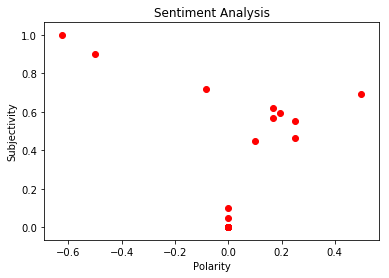

In [13]:
# Scatter plot of the polarity numeric scores.

plt.scatter(df.Polarity, df.Subjectivity, color='red')
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')                      # 0.00 is neutral
plt.ylabel('Subjectivity')

In [14]:
# Sentiment label breakdown, total, percentage 

# Create a sentiment dataframe. 
df_sentiment = pd.DataFrame(
    df.Sentiment.value_counts(normalize=True)*100 
)

# Add a column called total. Set to the value counts of the df.Sentiment column.
df_sentiment['Total'] = df.Sentiment.value_counts() 

df_sentiment['Percentage'] = df.Sentiment.value_counts() / 100 * 100                         # the percentage column should total 100 percent. this is not calculatiing correctly. 


df_sentiment


,Sentiment,Total,Percentage
Neutral,54.545455,12,12.0
Positve,31.818182,7,7.0
Negative,13.636364,3,3.0


In [31]:
# create stopwords
nltk.download('stopwords')
stpwrd = set(nltk.corpus.stopwords.words('english'))

# Combining all tweets text
allWords = ' '.join([twts for twts in df['Tweets']])

# Bring in an image of Elon as a mask to shape our word cloud.
mask = np.array(Image.open(d, "elon_headshot.webp"))


# Define a function WC to make word cloud.

def WC(data, title, mask=None):
    wc =  WordCloud(                              # make a WordCloud object.
        width = 500,
        height = 500,
        scale=3,
        random_state=21,
        colormap='autumn',
        mask=mask,
        stopwords=stpwrd,
        collocations=True
    ).generate(data)                                # take the allWords and generate cloud based on that. 

    plt.figure(figsize=(20,12))
    Cloud.to_file(str(title)+'.png') 
    plt.imshow(wc)
    plt.axis('off')
    fontdict = {'fontsize' : 20, 'fontweight' : 'bold'}
    plt.title(title, fontdict=fontdict)
    plt.show()                                      # no return statement???? 

# call the WC function, pass 

WC(allWords, 'Elon Musk', mask=mask)              # no word cloud is produced by this line. 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'Elon' is not defined

In [28]:
wc = WordCloud().generate(allWords)
plt.show()